In [27]:
import pandas as pd
from pytrends.request import TrendReq

# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [28]:
y = pd.read_csv("AAPL_quarterly_financials.csv", index_col="name")


In [29]:
y = pd.DataFrame(y.loc['BasicEPS',:]).iloc[2:,:]

In [ ]:
y.index = pd.to_datetime(y.index)
y = y.sort_index().fillna(0.)

In [75]:
y = y[y.index >= '2004-01-01']
y

,BasicEPS
2004-03-31,0.002
2004-06-30,0.003
2004-09-30,0.0
2004-12-31,0.013
2005-03-31,0.013
...,...
2022-06-30,1.2
2022-09-30,1.29
2022-12-31,1.89
2023-03-31,1.53


# 2.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [195]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ['Apple Event','Technology','iPhone','Innovation','IOS','Black Friday','Banana','Pet','Oil Price']
start_date = '2004-01-01'
end_date = '2023-06-30'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [196]:
df = df.resample('Q').mean()

In [197]:
df

,Apple Event,Technology,iPhone,Innovation,IOS,Black Friday,Banana,Pet,Oil Price
date,,,,,,,,,
2004-03-31,0.666667,99.000000,0.000000,91.333333,1.000000,0.000000,37.666667,69.333333,5.666667
2004-06-30,1.666667,89.000000,0.000000,86.666667,1.666667,0.000000,41.333333,69.333333,8.666667
2004-09-30,1.000000,84.333333,0.000000,80.000000,1.333333,0.000000,41.333333,75.333333,11.000000
2004-12-31,1.333333,78.666667,0.000000,83.333333,1.000000,0.666667,46.333333,70.000000,12.666667
2005-03-31,1.333333,82.000000,0.000000,86.666667,1.000000,0.000000,45.333333,68.333333,9.333333
...,...,...,...,...,...,...,...,...,...
2022-06-30,6.000000,29.666667,45.333333,83.000000,13.333333,1.000000,65.666667,81.000000,42.333333
2022-09-30,36.666667,30.000000,54.333333,76.333333,18.666667,1.333333,68.000000,83.333333,43.666667
2022-12-31,5.666667,28.000000,50.333333,79.000000,16.333333,19.666667,62.333333,79.666667,34.666667


# 3.) Normalize all the X data

In [198]:
from sklearn.preprocessing import StandardScaler

In [199]:
scaler = StandardScaler()

In [200]:
X_scaled = scaler.fit_transform(df)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [201]:
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

In [217]:
lasso = Lasso(alpha = 0.05) # use 0.05 instead of 0.5 because 0.5 whill shrink all coef to 0

In [218]:
model = lasso.fit(X_scaled,y)

In [219]:
coefficients = model.coef_

In [220]:
coefficients

array([ 0.        , -0.        ,  0.05322466,  0.        ,  0.        ,
        0.13757165,  0.1913834 ,  0.07277802,  0.05666409])

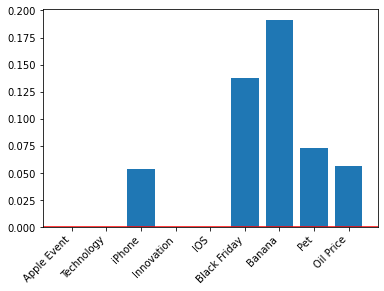

In [221]:
plt.bar(range(len(coefficients)), coefficients, tick_label=df.columns)
plt.xticks(range(len(coefficients)), df.columns, rotation=45, ha='right')
plt.axhline(0, color = 'r')
plt.show()

# 5.) Do these coefficient magnitudes make sense?

- Does not make that sense because the three factors that seems to have no relationship with apple's EPS has higher coef magnitude, while those that are supposed to be keywords for apple are penalized more and shrinked to 0 in the model.

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

# 7.) Run a cross validation. What is your ideal lambda?